In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

import glob

## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

from scipy.optimize import minimize


from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
# modellist=modellist_orig

# to match Sanderson paper:
modellist_ben=['ACCESS-ESM1-5',
                'CESM2',
                'GFDL-ESM4',
                'GISS_E2.1',
                'NorESM2-LM',
                'MPI-ESM1-2-LR',
                'CNRM-ESM2-1',
                'UKESM1.2',
                # 'UVic-ESCM-2-10',
                'HadCM3LC-Bris']

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

# modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
# bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]
bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "gold"]

# -----select either original colors or ben's colors and order
modellist=modellist_ben
modelcolors=bencolors

latlist=['global','highlat','midlat','troplat']

markerlist=['o','v','^','<','>','s','*','P','d','X']


vegcolor=color=np.divide([176, 208, 65],255)
littercolor=np.divide([240, 155, 56],255)
soilcolor=np.divide([164, 119, 39],255)

subplotlabelnames=['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [4]:
data_dict={}
data_dict = load_grid(data_dict,modellist)


ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
UKESM1.2 getting grid info
HadCM3LC-Bris getting grid info


In [21]:
modellist=['CNRM-ESM2-1']
unitconvert=PgperKg

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'cVeg')

    ###---- grid info
    lat = ds0g.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- cVeg
    var='cVeg'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 99) # first 100 years of flat10
    ds0_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon') # converted to PgC
    dst=select_time_slice(dsw, 0, 9) # first 100 years of flat10
    dsften = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC


    
    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    ds1_cVeg_PgC = unitconvert*(dsw*landarea).sum(dim='lon')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    ds2_cVeg_PgC = unitconvert*(dsw*landarea).sum(dim='lon')# converted to PgC

    # merge in time
    dszec=xr.concat([ds0_cVeg_PgC-dsften,ds1_cVeg_PgC-dsften],dim='time')
    dscdr=xr.concat([ds0_cVeg_PgC-dsften,ds2_cVeg_PgC-dsften],dim='time')
    

Plotting CNRM-ESM2-1
loading variable: cVeg
finished loading CNRM-ESM2-1 *lat10 cVeg
loading variable: cVeg
finished loading CNRM-ESM2-1 *lat10 cVeg
loading variable: cVeg
finished loading CNRM-ESM2-1 *zec cVeg
loading variable: cVeg
finished loading CNRM-ESM2-1 *cdr cVeg


In [15]:
dszec=xr.concat([ds0_cVeg_PgC,ds1_cVeg_PgC],dim='time')
# ds0_cVeg_PgC
# ds1_cVeg_PgC

dszec

<xarray.DataArray (time: 350, lat: 128)> Size: 358kB
dask.array<concatenate, shape=(350, 128), dtype=float64, chunksize=(1, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * time     (time) object 3kB 1850-01-01 00:00:00 ... 2199-01-01 00:00:00
    type     |S255 255B b'typeland\x00                                       ...

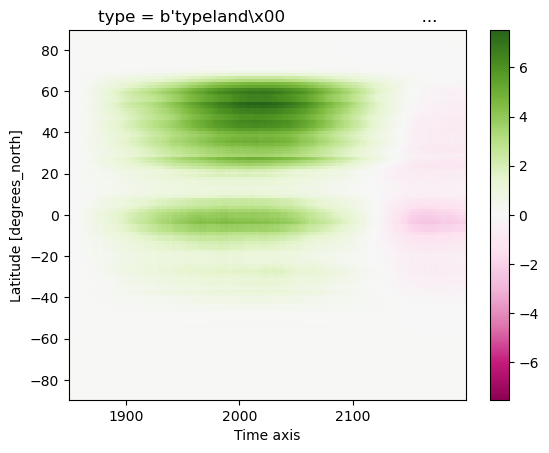

In [23]:
(dscdr).plot(x='time',cmap='PiYG')#, add_colorbar=False, ax=ax)

In [37]:
matdata=dscdr.values
lat=dscdr.lat
time=np.arange(0,350)

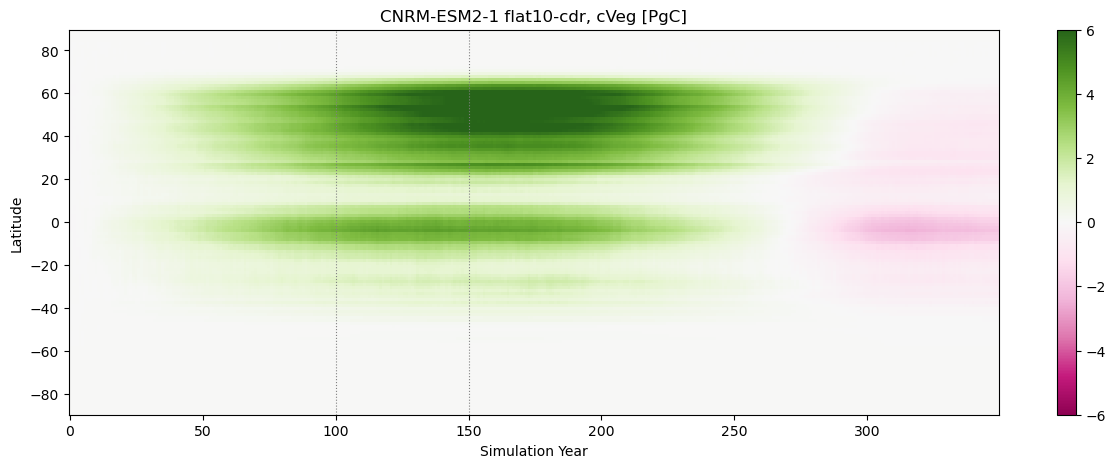

In [49]:
fig, axs = plt.subplots(1,1, figsize=(15, 5))

plt.pcolor(time,lat,np.transpose(matdata),cmap='PiYG',vmin=-6,vmax=6)#,ax=axs)#, add_colorbar=False, ax=ax)
plt.colorbar()
# axs.set_xticks([1900,1950,2000])


plt.axvline(100,lw=0.8,color="gray",linestyle=":")
plt.axvline(150,lw=0.8,color="gray",linestyle=":")

plt.ylabel('Latitude')
plt.xlabel('Simulation Year')
plt.title(model +' flat10-cdr, cVeg [PgC]')


# plt.show()
plt.savefig("figures/zonal_timeseries_cVeg_CNRM.png", bbox_inches='tight', dpi=800)
plt.show()
plt.close()

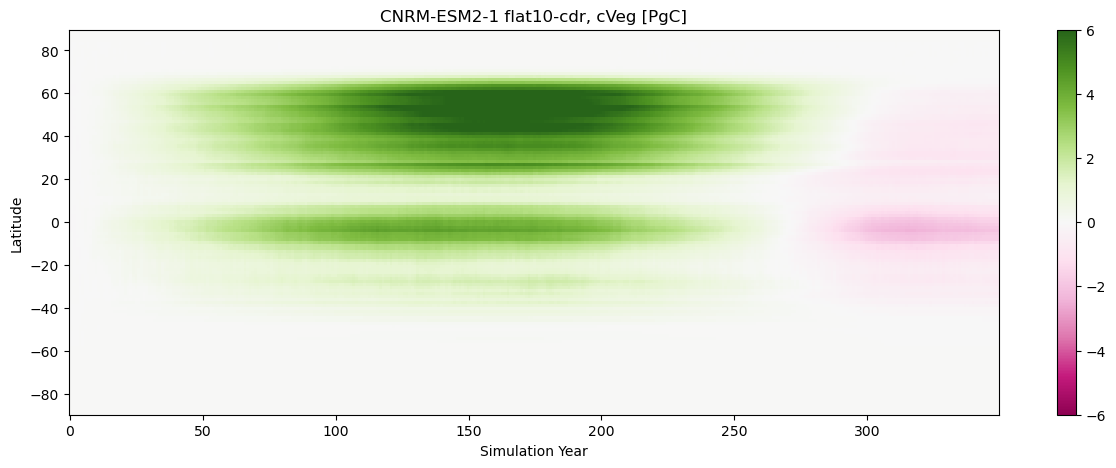

In [50]:
fig, axs = plt.subplots(1,1, figsize=(15, 5))

plt.pcolor(time,lat,np.transpose(matdata),cmap='PiYG',vmin=-6,vmax=6)#,ax=axs)#, add_colorbar=False, ax=ax)
plt.colorbar()
# axs.set_xticks([1900,1950,2000])


# plt.axvline(100,lw=0.8,color="gray",linestyle=":")
# plt.axvline(150,lw=0.8,color="gray",linestyle=":")

plt.ylabel('Latitude')
plt.xlabel('Simulation Year')
plt.title(model +' flat10-cdr, cVeg [PgC]')


# plt.show()
plt.savefig("figures/zonal_timeseries_cVeg_CNRM_nolines.png", bbox_inches='tight', dpi=800)
plt.show()
plt.close()

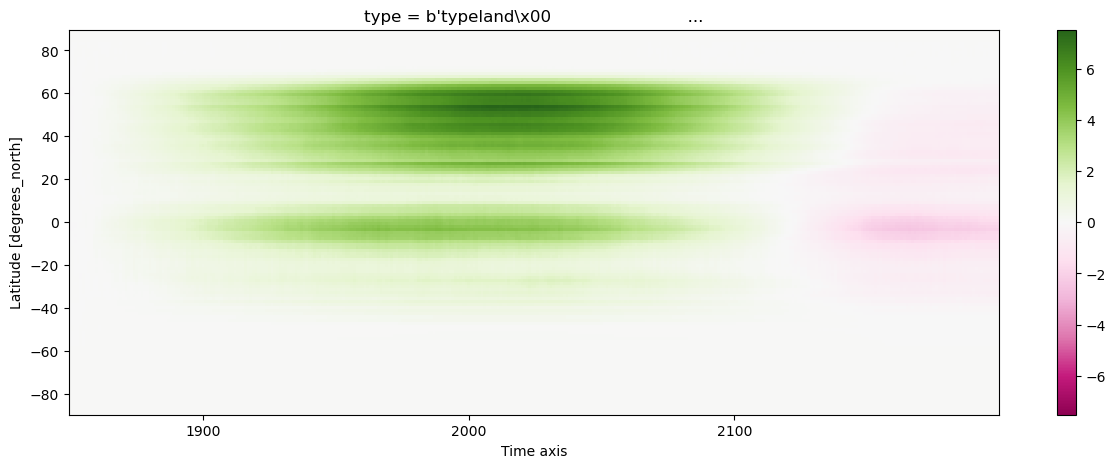

In [27]:
fig, axs = plt.subplots(1,1, figsize=(15, 5))

(dscdr).plot(x='time',cmap='PiYG',ax=axs)#, add_colorbar=False, ax=ax)

In [28]:
    #----###-----####----- cSoil
    var='cSoil'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cLitter
    var='cLitter'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    if ds0 is not None:
        # ds0=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds0,var) # annual mean    
        # del ds # drop full grid from memory   
        dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
        dsften_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dsften_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
        dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
        dslten0_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten0_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
        # ds1=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds1,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
        dslten1_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten1_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
        # ds2=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds2,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
        dslten2_cLitter = dst .mean(dim='time').mean(dim='lon') # original units
        dslten2_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
    
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, Litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil + dsften_cLitter
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC + dsften_cLitter_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil + dslten0_cLitter
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC + dslten0_cLitter_PgC
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil + dslten1_cLitter
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC + dslten1_cLitter_PgC
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil + dslten2_cLitter
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC + dslten2_cLitter_PgC

    else: # litter variable doesn't exist
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, but NOT litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil 
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC 
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil 
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC 
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil 
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC 

    #  drop some things from memory
    del ds0, ds1, ds2
    

loading variable: cSoil
finished loading CNRM-ESM2-1 *lat10 cSoil
loading variable: cSoil
finished loading CNRM-ESM2-1 *zec cSoil
loading variable: cSoil
finished loading CNRM-ESM2-1 *cdr cSoil
loading variable: cLitter
finished loading CNRM-ESM2-1 *lat10 cLitter
loading variable: cLitter


KeyboardInterrupt: 

In [ ]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

phasename=['InitialC','EmissionsPhase','NetZero','CumulativeZero']

num_rows=2
num_cols=5
fig0, axes0 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # initial C
fig1, axes1 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # emissions phase
fig2, axes2 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # net zero
fig3, axes3 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # cumulative zero

axes0=axes0.flatten()
axes1=axes1.flatten()
axes2=axes2.flatten()
axes3=axes3.flatten()


unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'cVeg')

    ###---- grid info
    lat = ds0g.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- cVeg
    var='cVeg'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cSoil
    var='cSoil'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cLitter
    var='cLitter'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    if ds0 is not None:
        # ds0=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds0,var) # annual mean    
        # del ds # drop full grid from memory   
        dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
        dsften_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dsften_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
        dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
        dslten0_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten0_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
        # ds1=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds1,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
        dslten1_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten1_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
        # ds2=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds2,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
        dslten2_cLitter = dst .mean(dim='time').mean(dim='lon') # original units
        dslten2_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
    
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, Litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil + dsften_cLitter
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC + dsften_cLitter_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil + dslten0_cLitter
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC + dslten0_cLitter_PgC
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil + dslten1_cLitter
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC + dslten1_cLitter_PgC
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil + dslten2_cLitter
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC + dslten2_cLitter_PgC

    else: # litter variable doesn't exist
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, but NOT litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil 
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC 
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil 
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC 
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil 
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC 

    #  drop some things from memory
    del ds0, ds1, ds2
    
    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]


    #--------------------------Second row is total carbon units (PgC)
    #---First column is flat10 climatology
    #--- first figure is the climatology, or average of first 10 years 
    ax = axes0[m]


    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total C')
    ax.plot(dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg_PgC+dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil_PgC,dsften_cSoil_PgC+dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([0, 100])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    #--- Second figure is end of flat10 emissions phase
    ax = axes1[m]
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)
    

    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten0_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg_PgC+dslten0_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil_PgC-dsften_cSoil_PgC,(dslten0_cSoil_PgC-dsften_cSoil_PgC)+(dslten0_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')

    ax.set_xlim([-1, 14])
    ax.annotate(subplotlabelnames[m],
                         xy=(0.8, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')

    #--- Third figure is end of flat10zec phase
    ax = axes2[m] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot_PgC-dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten1_cSoil_PgC-dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg_PgC+dslten1_cSoil_PgC)-(dslten0_cVeg_PgC+dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil_PgC-dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil_PgC-dslten0_cSoil_PgC,(dslten1_cSoil_PgC-dslten0_cSoil_PgC)+(dslten1_cVeg_PgC-dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
        
    #--- Fourth figure is end of flat10cdr phase

    ax = axes3[m] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten2_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg_PgC+dslten2_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil_PgC-dsften_cSoil_PgC,(dslten2_cSoil_PgC-dsften_cSoil_PgC)+(dslten2_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])

    if m>num_cols-2:
        ax.set_xlabel('[PgC]')

    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

# add gridlines
#axes0[m].grid(True,alpha=0.2, zorder=0)

# add legend
axes0[0].legend(loc='lower right')
axes1[0].legend(loc='lower right')
axes2[0].legend(loc='lower right')
axes3[0].legend(loc='lower right')

# remve the empty plot in the last slot - if we add a 10th model will need to disable this!
axes0[9].set_visible(False) 
axes1[9].set_visible(False)
axes2[9].set_visible(False) 
axes3[9].set_visible(False)

# set title over whole plot
yh=0.92
fig0.suptitle('Initial Carbon Stocks (beginning of flat10)',y=yh)
fig1.suptitle('Carbon gained during emissions phase (end of flat10 - beginning of flat10)',y=yh)
fig2.suptitle('Carbon change after net-zero (end of flat10zec - end of flat10)',y=yh)
fig3.suptitle('Carbon change at cumulative zero emissions (end of flat10cdr - beginning of flat10)',y=yh)

# save the plot
fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[0] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig0)
plt.close(fig0)

fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[1] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig1)
plt.close(fig1)

fig2.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[2] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig2)
plt.close(fig2)

fig3.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[3] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig3)
plt.close(fig3)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
# plt.close()
